# Goal: Correct for singles rate with $W$ calculation
In order to correct for differences in detection efficiencies and solid angles, we will divide all of the doubles rates by the singles rates of the two detectors as follows:

$ W_{i,j} = \frac{D_{i,j}}{S_i*S_j}$

This requires calculating $S_i$ and $S_j$ from the `cced` files. I need to rewrite my analysis from the beginning, or write another function that parses the `cced` file.

In this file, I will import the singles and bicorr data and calculate all  $D_{i,j}$, $S_i$, $S_j$, and $W_{i,j}$. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style='ticks')

In [4]:
sys.path.append('../scripts/')

In [5]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [6]:
%load_ext autoreload
%autoreload 2

# Load some data

I'm going to work with the data from the combined data sets. The analysis for this data set is in `analysis\Cf072115_to_Cf072215b`.

The one limitation here is that this data has already cut out the fission chamber neighbors. 

## `det_df` without fission chamber neighbors

In [7]:
det_df = bicorr.load_det_df('../meas_info/det_df_pairs_angles.csv')
pair_is = bicorr.generate_pair_is(det_df,ignore_fc_neighbors_flag=True)
det_df = det_df.loc[pair_is].reset_index().rename(columns={'index':'index_og'}).copy()
det_df.head()

,index_og,d1,d2,d1d2,angle
0,44,2,3,203,15.0
1,45,2,4,204,30.0
2,46,2,5,205,45.0
3,47,2,6,206,60.0
4,48,2,7,207,75.0


In [8]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()
dict_pair_to_index, dict_index_to_pair, dict_pair_to_angle = bicorr.build_dict_det_pair(det_df)

In [9]:
num_fissions = 2194651200.00

## `singles_hist.npz`

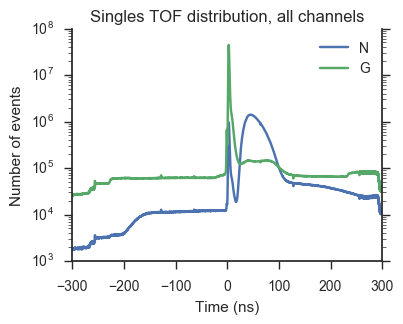

In [11]:
singles_hist, dt_bin_edges_sh, dict_det_to_index, dict_index_to_det = bicorr.load_singles_hist(filepath='../analysis/Cf072115_to_Cf072215b/datap',plot_flag=True,show_flag=True)

## Load `bhp_nn` for all pairs

I'm going to skip a few steps in order to save memory. This data was produced in `analysis_build_bhp_nn_by_pair_1_ns.ipynb` and is stored in `datap\bhp_nn_by_pair_1ns.npz`. Load it now, as explained in the notebook.

In [12]:
npzfile = np.load('../analysis/Cf072115_to_Cf072215b/datap/bhp_nn_by_pair_1ns.npz')
pair_is = npzfile['pair_is']
bhp_nn_pos = npzfile['bhp_nn_pos']
bhp_nn_neg = npzfile['bhp_nn_neg']
dt_bin_edges = npzfile['dt_bin_edges']

The fission chamber neighbors have already been removed

In [13]:
len(pair_is)

861

## Specify energy range

In [14]:
emin = 0.62
emax = 12

# Calculate sums

## Singles- set up `singles_df`

I will store this in a pandas dataframe.

Columns:

* Channel number
* `Sp` - Singles counts, positive
* `Sn` - Singles counts, negative
* `Sd` - Singles counts, br-subtracted
* `Sd_err` - Singles counts, br-subtracted, err

In [15]:
singles_df = pd.DataFrame.from_dict(dict_index_to_det,orient='index',dtype=np.int8).rename(columns={0:'ch'})
chIgnore = [1,17,33]
singles_df = singles_df[~singles_df['ch'].isin(chIgnore)].copy()

In [16]:
singles_df['Sp']= 0.0
singles_df['Sn']= 0.0
singles_df['Sd']= 0.0
singles_df['Sd_err'] = 0.0

## Singles- calculate sums

In [17]:
for index in singles_df.index.values:
    Sp, Sn, Sd, Sd_err = bicorr.calc_n_sum_br(singles_hist, dt_bin_edges_sh, index, emin=emin, emax=emax)
    singles_df.loc[index,'Sp'] = Sp
    singles_df.loc[index,'Sn'] = Sn
    singles_df.loc[index,'Sd'] = Sd
    singles_df.loc[index,'Sd_err'] = Sd_err

In [18]:
singles_df.head()

,ch,Sp,Sn,Sd,Sd_err
1,2,5150169.0,76920.0,5073249.0,2286.282791
2,3,5024494.0,73426.0,4951068.0,2257.857391
3,4,5391714.0,76594.0,5315120.0,2338.441361
4,5,5717925.0,81136.0,5636789.0,2408.123959
5,6,5448282.0,71482.0,5376800.0,2349.417800


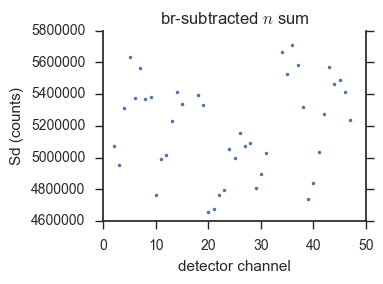

In [19]:
bicorr_plot.Sd_vs_angle_all(singles_df)

## Doubles- set up `det_df`

In [20]:
det_df.head()

,index_og,d1,d2,d1d2,angle
0,44,2,3,203,15.0
1,45,2,4,204,30.0
2,46,2,5,205,45.0
3,47,2,6,206,60.0
4,48,2,7,207,75.0


In [21]:
det_df['Cp'] = 0.0
det_df['Cn'] = 0.0
det_df['Cd'] = 0.0
det_df['Cd_err'] = 0.0
det_df['Np'] = 0.0
det_df['Nn'] = 0.0
det_df['Nd'] = 0.0
det_df['Nd_err'] = 0.0

In [22]:
det_df.head()

,index_og,d1,d2,d1d2,angle,Cp,Cn,Cd,Cd_err,Np,Nn,Nd,Nd_err
0,44,2,3,203,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45,2,4,204,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,46,2,5,205,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,2,6,206,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,48,2,7,207,75.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Doubles- Calculate sums

In [23]:
for index in det_df.index.values:
    Cp, Cn, Cd, err_Cd = bicorr.calc_nn_sum_br(bhp_nn_pos[index,:,:],
                                               bhp_nn_neg[index,:,:],
                                               dt_bin_edges,
                                               emin=emin, emax=emax)
    det_df.loc[index,'Cp'] = Cp
    det_df.loc[index,'Cn'] = Cn
    det_df.loc[index,'Cd'] = Cd
    det_df.loc[index,'Cd_err'] = err_Cd
    Np, Nn, Nd, err_Nd = bicorr.calc_nn_sum_br(bhp_nn_pos[index,:,:],
                                               bhp_nn_neg[index,:,:],
                                               dt_bin_edges,
                                               emin=emin, emax=emax,
                                               norm_factor = num_fissions)
    det_df.loc[index,'Np'] = Np
    det_df.loc[index,'Nn'] = Nn
    det_df.loc[index,'Nd'] = Nd
    det_df.loc[index,'Nd_err'] = err_Nd

In [24]:
det_df.head()

,index_og,d1,d2,d1d2,angle,Cp,Cn,Cd,Cd_err,Np,Nn,Nd,Nd_err
0,44,2,3,203,15.0,22338.0,229.0,22109.0,150.223167,22338.0,229.0,22109.0,0.003207
1,45,2,4,204,30.0,14779.0,129.0,14650.0,122.098321,14779.0,129.0,14650.0,0.002606
2,46,2,5,205,45.0,14042.0,116.0,13926.0,118.987394,14042.0,116.0,13926.0,0.002540
3,47,2,6,206,60.0,11993.0,121.0,11872.0,110.063618,11993.0,121.0,11872.0,0.002349
4,48,2,7,207,75.0,11707.0,104.0,11603.0,108.678425,11707.0,104.0,11603.0,0.002320


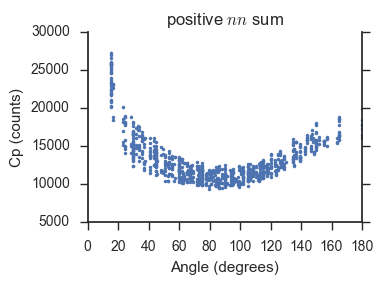

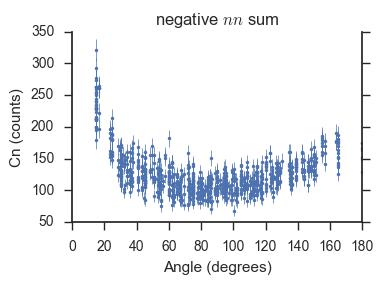

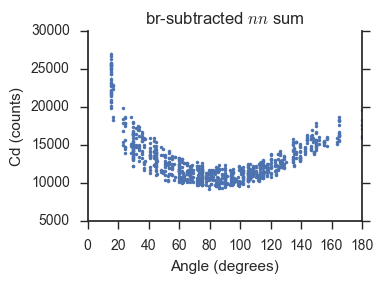

yes


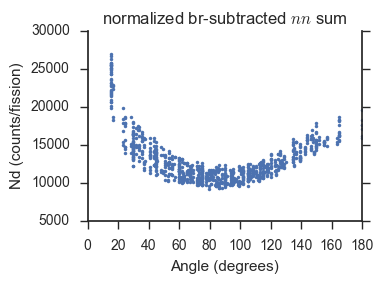

In [25]:
bicorr_plot.counts_vs_angle_all(det_df, normalized=True)

# Perform the correction

Now I am going to loop through all pairs and calculate $W$.

* Loop through each pair
* Identify $i$, $j$
* Fetch $S_i$, $S_j$
* Calculate $W$
* Propagate error for $W_{err}$
* Store in `det_df`

## Add `W`, `W_err` columns to `det_df`

In [26]:
det_df['Sd1']     = 0.0
det_df['Sd1_err'] = 0.0
det_df['Sd2']     = 0.0
det_df['Sd2_err'] = 0.0

det_df['W']     = 0.0
det_df['W_err'] = 0.0

In [27]:
det_df.head()

,index_og,d1,d2,d1d2,angle,Cp,Cn,Cd,Cd_err,Np,Nn,Nd,Nd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,44,2,3,203,15.0,22338.0,229.0,22109.0,150.223167,22338.0,229.0,22109.0,0.003207,0.0,0.0,0.0,0.0,0.0,0.0
1,45,2,4,204,30.0,14779.0,129.0,14650.0,122.098321,14779.0,129.0,14650.0,0.002606,0.0,0.0,0.0,0.0,0.0,0.0
2,46,2,5,205,45.0,14042.0,116.0,13926.0,118.987394,14042.0,116.0,13926.0,0.002540,0.0,0.0,0.0,0.0,0.0,0.0
3,47,2,6,206,60.0,11993.0,121.0,11872.0,110.063618,11993.0,121.0,11872.0,0.002349,0.0,0.0,0.0,0.0,0.0,0.0
4,48,2,7,207,75.0,11707.0,104.0,11603.0,108.678425,11707.0,104.0,11603.0,0.002320,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
singles_df.head()

,ch,Sp,Sn,Sd,Sd_err
1,2,5150169.0,76920.0,5073249.0,2286.282791
2,3,5024494.0,73426.0,4951068.0,2257.857391
3,4,5391714.0,76594.0,5315120.0,2338.441361
4,5,5717925.0,81136.0,5636789.0,2408.123959
5,6,5448282.0,71482.0,5376800.0,2349.417800


## Loop through `det_df`, store singles rates

Fill the `S` and `S_err` values for each channel in each detector pair.

In [30]:
# Fill S columns in det_df
for index in singles_df.index.values:
    ch = singles_df.loc[index,'ch']
    
    d1_indices = (det_df[det_df['d1'] == ch]).index.tolist()
    d2_indices = (det_df[det_df['d2'] == ch]).index.tolist()
    
    det_df.loc[d1_indices,'Sd1']     = singles_df.loc[index,'Sd']
    det_df.loc[d1_indices,'Sd1_err'] = singles_df.loc[index,'Sd_err']
    det_df.loc[d2_indices,'Sd2']     = singles_df.loc[index,'Sd']
    det_df.loc[d2_indices,'Sd2_err'] = singles_df.loc[index,'Sd_err']

In [38]:
# Calculate W, W_err from S columns
det_df['W'] = det_df['Cd']/(det_df['Sd1']*det_df['Sd2'])

In [39]:
det_df['W_err'] = det_df['W'] * np.sqrt((det_df['Cd_err']/det_df['Cd'])**2 + 
                                        (det_df['Sd1_err']/det_df['Sd1'])**2 + 
                                        (det_df['Sd2_err']/det_df['Sd2'])**2)

In [40]:
det_df.head()

,index_og,d1,d2,d1d2,angle,Cp,Cn,Cd,Cd_err,Np,Nn,Nd,Nd_err,Sd1,Sd1_err,Sd2,Sd2_err,W,W_err
0,44,2,3,203,15.0,22338.0,229.0,22109.0,150.223167,22338.0,229.0,22109.0,0.003207,5073249.0,2286.282791,4951068.0,2257.857391,8.802054e-10,6.007264e-12
1,45,2,4,204,30.0,14779.0,129.0,14650.0,122.098321,14779.0,129.0,14650.0,0.002606,5073249.0,2286.282791,5315120.0,2338.441361,5.432983e-10,4.540952e-12
2,46,2,5,205,45.0,14042.0,116.0,13926.0,118.987394,14042.0,116.0,13926.0,0.002540,5073249.0,2286.282791,5636789.0,2408.123959,4.869770e-10,4.171833e-12
3,47,2,6,206,60.0,11993.0,121.0,11872.0,110.063618,11993.0,121.0,11872.0,0.002349,5073249.0,2286.282791,5376800.0,2349.417800,4.352250e-10,4.044147e-12
4,48,2,7,207,75.0,11707.0,104.0,11603.0,108.678425,11707.0,104.0,11603.0,0.002320,5073249.0,2286.282791,5564633.0,2394.397419,4.110055e-10,3.858153e-12


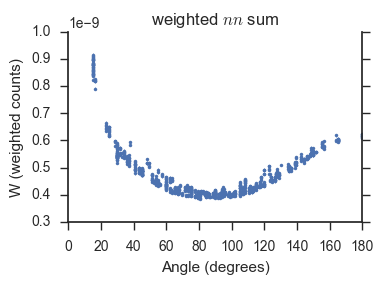

In [44]:
bicorr_plot.W_vs_angle_all(det_df)

This is much "tighter" than the raw counts. 